In [119]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import lightgbm as lgb

In [120]:
#df = pd.read_csv("공공/훈련데이터셋.csv")
#df.info()

In [121]:
df = pd.read_csv("공공/법정동_일별_날씨_전력량.csv")
#df.info()

In [122]:
df.head(4)

,전체코드,시군구코드,시군구명,법정동코드,법정동명,날짜,파워,평균기온(°C),최저기온(°C),최고기온(°C),...,평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm)
0,1111010100,11110,종로구,10100,청운동,2022-12-04,146294.6135,-3.5,-5.2,-0.2,...,3.5,5.2,7.5,12.1,15.6,18.4,18.7,1.2,1.7,0.0
1,1111010100,11110,종로구,10100,청운동,2022-12-05,175633.8270,-3.1,-7.0,1.9,...,2.8,4.6,7.0,11.7,15.3,18.4,18.7,1.5,2.1,0.1
2,1111010100,11110,종로구,10100,청운동,2022-12-06,156084.1910,0.9,-3.9,5.3,...,2.4,4.1,6.6,11.3,15.1,18.3,18.7,1.3,1.9,0.1
3,1111010100,11110,종로구,10100,청운동,2022-12-08,177018.8420,3.7,0.1,9.1,...,3.6,4.8,6.6,10.7,14.5,18.2,18.6,1.5,2.2,0.0


In [123]:
df["날짜"] = pd.to_datetime(df["날짜"])

In [124]:
df["year"] = df["날짜"].dt.year
df["month"] = df["날짜"].dt.month
df["day"] = df["날짜"].dt.day
df["weekday"] = df["날짜"].dt.weekday  # 월=0
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

# 계절 주기 인식
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

In [125]:
# 온도 기반 파생 변수 (핵심)
df["일교차"] = df["최고기온(°C)"] - df["최저기온(°C)"]

df["냉방지수"] = np.maximum(0, df["평균기온(°C)"] - 24)
df["난방지수"] = np.maximum(0, 18 - df["평균기온(°C)"])

In [126]:
group_key = "법정동코드"

# 전력 Lag
df["파워_lag1"] = df.groupby(group_key)["파워"].shift(1)
df["파워_lag7"] = df.groupby(group_key)["파워"].shift(7)

# 기온 Lag / Rolling
df["평균기온_lag1"] = df.groupby(group_key)["평균기온(°C)"].shift(1)
df["평균기온_roll3"] = (
    df.groupby(group_key)["평균기온(°C)"]
      .shift(1)
      .rolling(3)
      .mean()
)

In [127]:
feature_cols = [
    # 식별
    "전체코드", "시군구코드", "법정동코드",

    # 기본 날씨
    "평균기온(°C)", "최저기온(°C)", "최고기온(°C)",
    "평균 상대습도(%)", "일강수량(mm)", "평균 풍속(m/s)",

    # 파생
    "일교차", "냉방지수", "난방지수",

    # 시간
    "weekday", "is_weekend", "month_sin", "month_cos",

    # Lag
    "파워_lag1", "파워_lag7",
    "평균기온_lag1", "평균기온_roll3",
]

target_col = "파워"

new_df = df[["날짜"] + feature_cols + [target_col]].dropna().reset_index(drop=True)

In [128]:
df = df.sort_values(["전체코드", "날짜"])  # 또는 법정동코드/전체코드 중 실제 키로

out = []
for code, g in df.groupby("전체코드"):
    g = g.set_index("날짜").asfreq("D")      # 빠진 날짜 생성
    g["전체코드"] = code
    out.append(g.reset_index())

df2 = pd.concat(out, ignore_index=True)

# 빠진 날짜의 파워 처리(선택)
# 1) 보간(부드럽게)
# df2["파워"] = df2.groupby("전체코드")["파워"].interpolate()

# 2) 전일값 유지(계단형)
# df2["파워"] = df2.groupby("전체코드")["파워"].ffill()

df2["파워_lag1"] = df2.groupby("전체코드")["파워"].shift(1)
df2["파워_lag7"] = df2.groupby("전체코드")["파워"].shift(7)

In [129]:

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

target_col = "파워"


In [130]:

# =========================
# 1) 시간순 Train/Valid/Test 분할
# =========================
new_df = new_df.sort_values("날짜").reset_index(drop=True)

n = len(new_df)
test_size = int(n * 0.20)
valid_size = int(n * 0.10)

train_end = n - (valid_size + test_size)
valid_end = n - test_size

train_df = new_df.iloc[:train_end]
valid_df = new_df.iloc[train_end:valid_end]
test_df  = new_df.iloc[valid_end:]


In [131]:
# =========================
# 2) X / y 분리
# =========================
drop_cols = [target_col, "날짜"]  # 날짜는 직접 입력 피처로 쓰지 않음(우린 파생변수로 이미 반영)
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]


In [132]:

# =========================
# 3) 범주형 처리 (코드형 컬럼은 category로)
# =========================
cat_cols = []
for c in ["전체코드", "시군구코드", "법정동코드"]:
    if c in X_train.columns:
        cat_cols.append(c)

for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_valid[c] = X_valid[c].astype("category")
    X_test[c]  = X_test[c].astype("category")


In [137]:
# =========================
# 4) LightGBM Baseline 모델
# =========================
model = LGBMRegressor(
    objective = "fair",
    n_estimators=20000,          # 상한: early stopping이 멈춤
    learning_rate=0.03,

    # 트리 복잡도(과적합 방지)
    num_leaves=63,
    max_depth=10,
    min_child_samples=120,       # ★ 핵심(=min_data_in_leaf)
    min_split_gain=0.10,

    # 샘플링
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,

    # 정규화
    reg_alpha=0.5,
    reg_lambda=8.0,

    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    categorical_feature=cat_cols if len(cat_cols) > 0 else "auto",
    callbacks=[
        # early stopping (너무 오래 돌지 않게)
        # verbose는 200번마다 한번씩 로그
        __import__("lightgbm").early_stopping(stopping_rounds=200, verbose=True),
        __import__("lightgbm").log_evaluation(period=200),
    ]
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 126561, number of used features: 20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 149453.395289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, max_depth=10,
              min_child_samples=120, min_split_gain=0.1, n_estimators=20000,
              n_jobs=-1, num_leaves=63, objective='fair', random_state=42,
              reg_alpha=0.5, reg_lambda=8.0, subsample=0.8, subsample_freq=1)

In [134]:

# =========================
# 5) 평가 (Valid / Test)
# =========================
def eval_print(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] RMSE: {rmse:,.3f}")
    print(f"[{name}] R2  : {r2:.6f}")
    return rmse, r2

pred_valid = model.predict(X_valid)
pred_test  = model.predict(X_test)

eval_print("VALID", y_valid, pred_valid)
eval_print("TEST",  y_test,  pred_test)

print("Best iteration:", model.best_iteration_)

[VALID] RMSE: 182,585.951
[VALID] R2  : 0.752255
[TEST] RMSE: 96,337.946
[TEST] R2  : 0.820164
Best iteration: 424


In [138]:
import pandas as pd

imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

imp.head(20)

,feature,importance
16,파워_lag1,161685
17,파워_lag7,135056
9,일교차,123433
6,평균 상대습도(%),110140
12,weekday,93219
0,전체코드,86292
19,평균기온_roll3,82699
8,평균 풍속(m/s),74930
5,최고기온(°C),57279
18,평균기온_lag1,53544


C:\Users\Admin\AppData\Local\Temp\ipykernel_11132\3826767946.py:6: UserWarning: Glyph 45257 (\N{HANGUL SYLLABLE NAENG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_11132\3826767946.py:6: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_11132\3826767946.py:6: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_11132\3826767946.py:6: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_11132\3826767946.py:6: UserWarning: Glyph 45212 (\N{HANGUL SYLLABLE NAN}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_11132\3826767946.py:6: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
C:\U

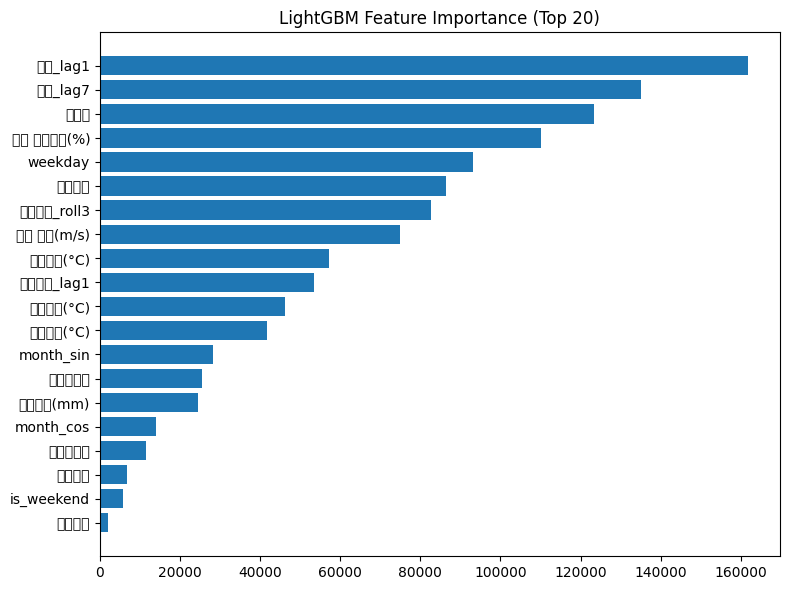

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(imp["feature"][:20][::-1], imp["importance"][:20][::-1])
plt.title("LightGBM Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

In [140]:
# =========================
# 예측 날짜
# =========================
pred_date = pd.to_datetime("2025-01-12")

# =========================
# 1) 고정 코드 값
# =========================
row = {
    "전체코드": 1111010100,
    "시군구코드": 11110,
    "법정동코드": 1111010100,
}

# =========================
# 2) 기상 예보 값 (예시)
# =========================
avg_temp = 3.5
min_temp = -2.0
max_temp = 7.0
humidity = 55
rain = 0.0
wind = 2.1

row.update({
    "평균기온(°C)": avg_temp,
    "최저기온(°C)": min_temp,
    "최고기온(°C)": max_temp,
    "평균 상대습도(%)": humidity,
    "일강수량(mm)": rain,
    "평균 풍속(m/s)": wind,
})

# =========================
# 3) 날씨 파생
# =========================
row["일교차"] = max_temp - min_temp
row["냉방지수"] = max(0, avg_temp - 24)
row["난방지수"] = max(0, 18 - avg_temp)

# =========================
# 4) 날짜 파생
# =========================
weekday = pred_date.weekday()
month = pred_date.month

row["weekday"] = weekday
row["is_weekend"] = int(weekday >= 5)
row["month_sin"] = np.sin(2 * np.pi * month / 12)
row["month_cos"] = np.cos(2 * np.pi * month / 12)

# =========================
# 5) lag / rolling (과거 데이터에서 계산)
# =========================
row["파워_lag1"] = 152_300
row["파워_lag7"] = 147_800
row["평균기온_lag1"] = 2.8
row["평균기온_roll3"] = 1.9

# =========================
# DataFrame 1행 생성
# =========================
X_pred = pd.DataFrame([row])

# category 처리 (학습 때와 동일해야 함)
for c in ["전체코드", "시군구코드", "법정동코드"]:
    X_pred[c] = X_pred[c].astype("category")

print(X_pred)

         전체코드  시군구코드       법정동코드  평균기온(°C)  최저기온(°C)  최고기온(°C)  평균 상대습도(%)  \
0  1111010100  11110  1111010100       3.5      -2.0       7.0          55   

   일강수량(mm)  평균 풍속(m/s)  일교차  냉방지수  난방지수  weekday  is_weekend  month_sin  \
0       0.0         2.1  9.0     0  14.5        6           1        0.5   

   month_cos  파워_lag1  파워_lag7  평균기온_lag1  평균기온_roll3  
0   0.866025   152300   147800        2.8         1.9  


In [141]:
y_pred = model.predict(X_pred)
print(f"예측 전력 사용량: {y_pred[0]:,.1f}")

예측 전력 사용량: 139,234.3


C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.draw()
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 54217 (\N{HANGUL SYL

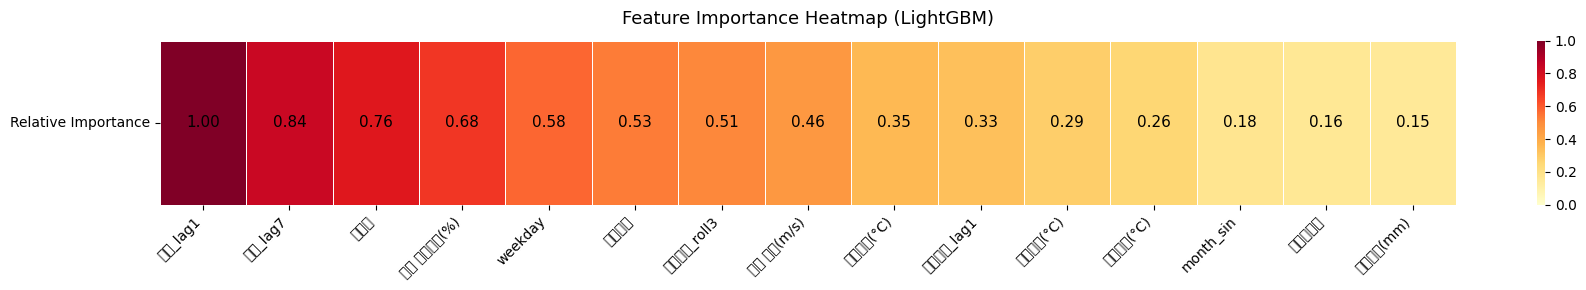

In [142]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================
# 0) 렌더링 설정 강제 초기화
# =========================
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"] = False

# =========================
# 1) Feature importance 정리
# =========================
fi = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

TOP_N = 15
fi_top = fi.head(TOP_N)
fi_norm = fi_top / fi_top.max()

heat_df = pd.DataFrame(
    fi_norm.values.reshape(1, -1),
    columns=fi_norm.index,
    index=["Relative Importance"]
)

# =========================
# 2) 히트맵
# =========================
plt.figure(figsize=(1.2 * TOP_N, 3))

sns.heatmap(
    heat_df,
    cmap="YlOrRd",
    annot=True,
    fmt=".2f",
    cbar=True,
    vmin=0,
    vmax=1,
    linewidths=0.5,
    annot_kws={
        "size": 11,
        "color": "black",
        "bbox": None  # ← 이 줄이 핵심
    }
)

plt.title("Feature Importance Heatmap (LightGBM)", fontsize=13, pad=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()